## Project Framing (CRISP-DM)

- **Business Goal**: Help a used car dealership understand which attributes most influence resale price and build a model to estimate price.
- **Data Mining Task**: Supervised **regression** using historical listings (features like year, odometer, condition, etc.) to predict **price**.
- **Success Criteria**: (1) An interpretable model with competitive error (e.g., MAE/RMSE baseline beats simple heuristics), (2) actionable insights on price drivers.


## Plan of Attack

1. **Load & sanity-check** the data; inspect schema, missingness, and basic distributions.
2. **Clean & prepare**: filter obvious outliers, impute missing values, and standardize/encode features.
3. **Explore**: visualize relationships (e.g., price vs. year, odometer), manufacturer summaries, and correlations.
4. **Model**: compare a linear baseline (**Ridge**) and a nonlinear model (**Random Forest**), using pipelines and validation.
5. **Interpret**: examine feature importances and permutation importance.
6. **Conclude**: summarize key drivers and recommendations.


In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


## Data Understanding

We use the Kaggle-style vehicles dataset (sample ~426k rows, 18 columns). Key fields include `price` (target),
`year`, `odometer`, `manufacturer`, `model`, `condition`, `fuel`, `transmission`, `drive`, `size`, `type`, `paint_color`, and `state`.
We will begin by loading, reviewing schema, and checking basic quality signals (missingness and ranges).


In [2]:
# Load dataset
data_path = 'data/vehicles.csv'
df = pd.read_csv(data_path)
df_original_shape = df.shape
df.head(3)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl


Original shape: (426880, 18)
Data types / non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  ob

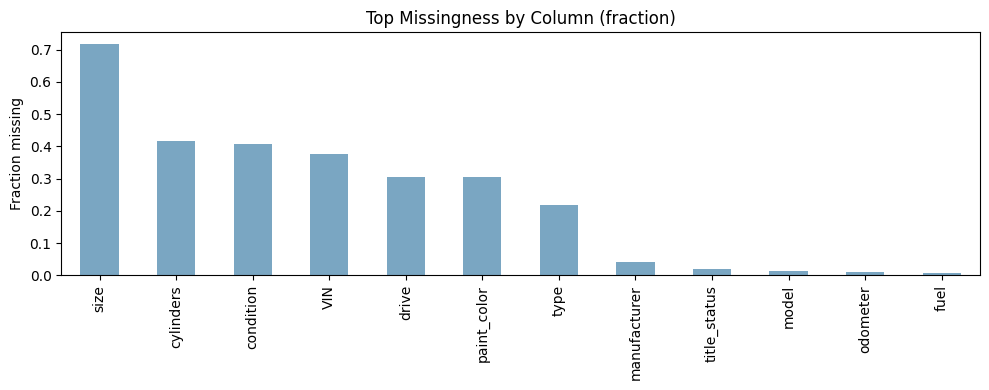

In [4]:
# Schema and missingness overview
print('Original shape:', df_original_shape)
print('Data types / non-null counts:')
print(df.info())

missing = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
missing.head(12).plot(kind='bar', color='#7aa6c2')
plt.title('Top Missingness by Column (fraction)')
plt.ylabel('Fraction missing')
plt.tight_layout()
plt.show()


## Data Cleaning & Preparation

We perform light cleaning to keep training stable and interpretable:

- Drop listings with non-positive or extremely low prices (e.g., `price <= 1000`).
- Remove a small fraction of extreme outliers by clipping the top 0.5% of `price` (robustness).
- Focus on features with manageable cardinality; drop very high-cardinality identifiers like `VIN`, `model`, and `region`.
- Create a working sample (up to 120k rows) for faster experimentation; you can adjust upward if resources allow.


In [5]:
# Basic filters and robust clipping
cars_df = df.copy()
cars_df = cars_df[cars_df['price'] > 1000]  # remove giveaways / mis-entries
upper_clip = cars_df['price'].quantile(0.995)
cars_df = cars_df[cars_df['price'] <= upper_clip]

# Choose features (limit very high-cardinality columns)
target_col = 'price'
candidate_features = [
    'year', 'odometer', 'manufacturer', 'condition', 'cylinders', 'fuel',
    'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state'
]
cars_df = cars_df[candidate_features + [target_col]].copy()

# Optional: sample for speed
if len(cars_df) > 120_000:
    cars_df = cars_df.sample(120_000, random_state=42).reset_index(drop=True)

cars_df.shape


(120000, 14)

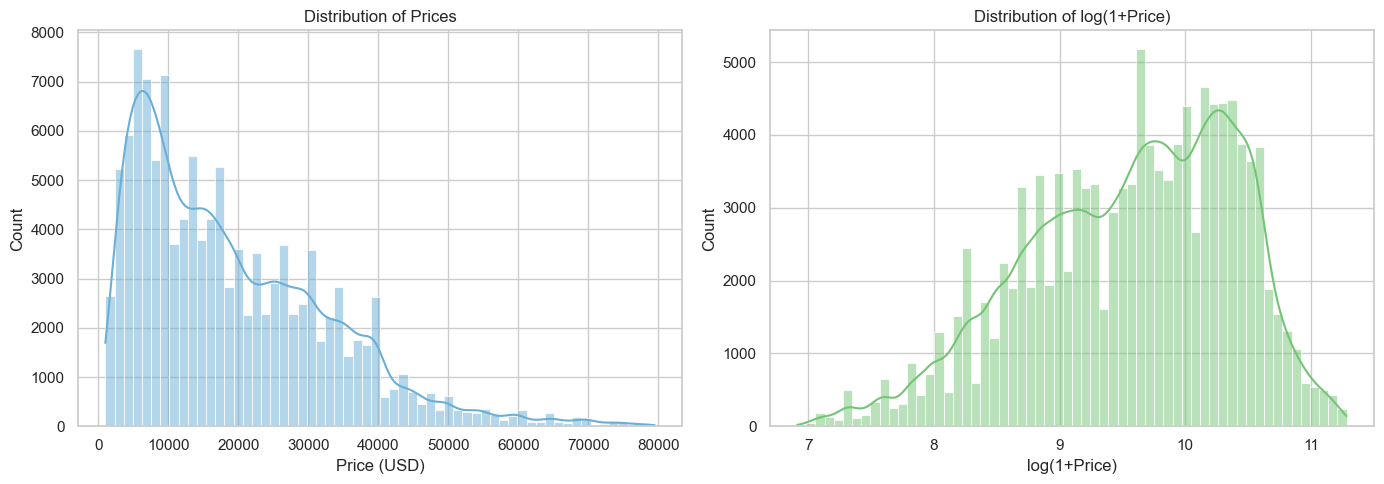

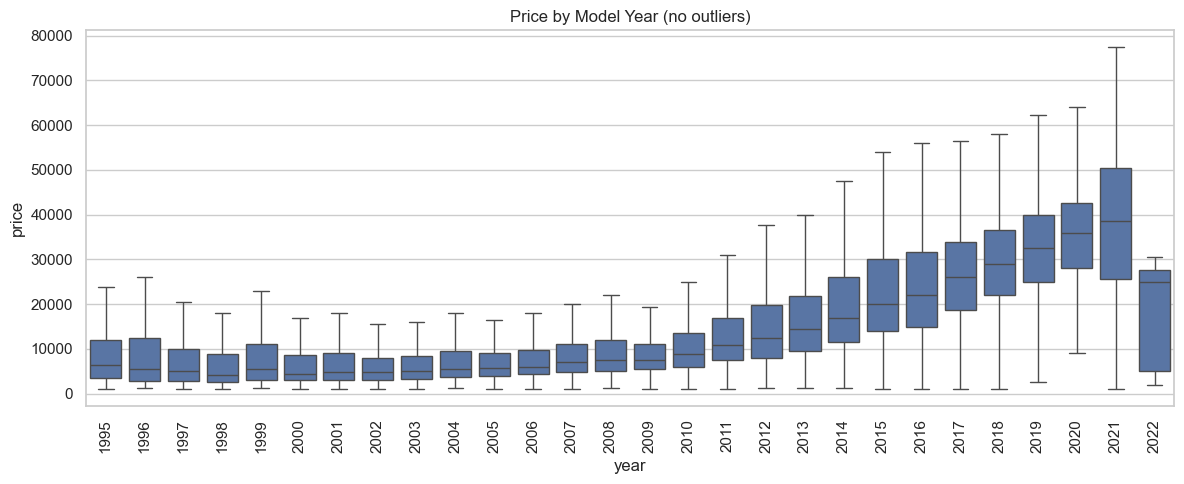

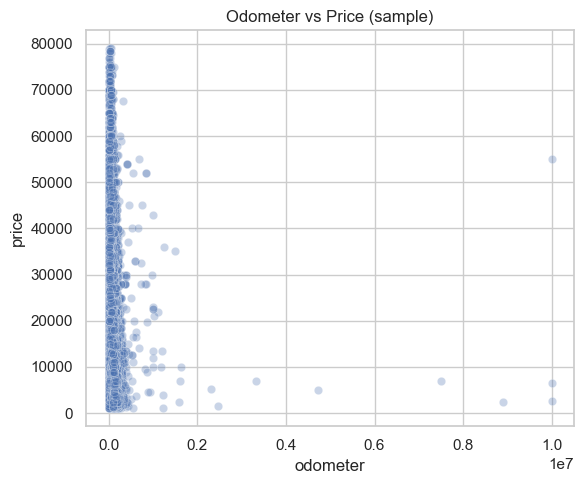

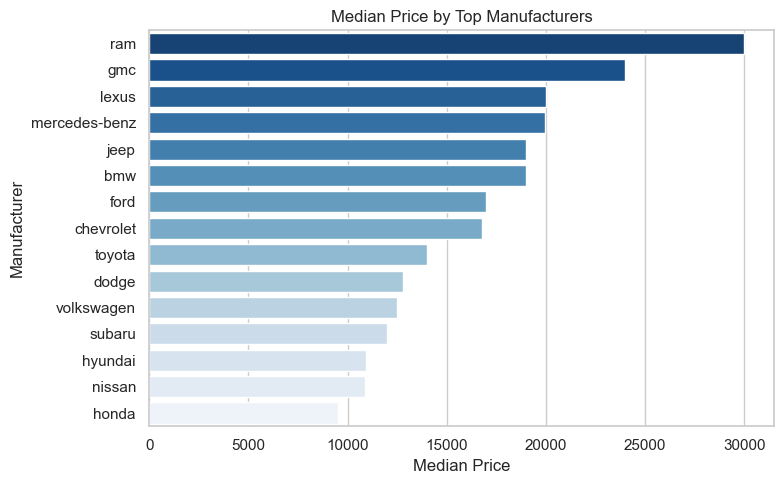

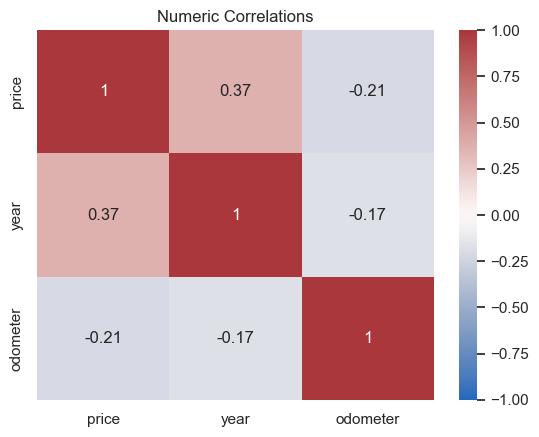

In [6]:
# EDA: distributions and bivariate views
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(cars_df['price'], bins=60, kde=True, ax=axes[0], color='#6baed6')
axes[0].set_title('Distribution of Prices')
axes[0].set_xlabel('Price (USD)')
axes[0].set_ylabel('Count')

# Log-price view for heavy right tail
sns.histplot(np.log1p(cars_df['price']), bins=60, kde=True, ax=axes[1], color='#74c476')
axes[1].set_title('Distribution of log(1+Price)')
axes[1].set_xlabel('log(1+Price)')
axes[1].set_ylabel('Count')
plt.tight_layout(); plt.show()

# Year vs price (boxplot)
plt.figure(figsize=(12,5))
tmp = cars_df.dropna(subset=['year']).copy()
tmp['year'] = tmp['year'].astype(int)
sns.boxplot(data=tmp[tmp['year']>=1995], x='year', y='price', showfliers=False)
plt.xticks(rotation=90)
plt.title('Price by Model Year (no outliers)')
plt.tight_layout(); plt.show()

# Odometer vs price
plt.figure(figsize=(6,5))
sns.scatterplot(data=cars_df.sample(min(len(cars_df), 20000), random_state=42), x='odometer', y='price', alpha=0.3)
plt.title('Odometer vs Price (sample)')
plt.tight_layout(); plt.show()

# Top manufacturers by listing count & their median prices
top_makes = cars_df['manufacturer'].value_counts().head(15).index
agg = (cars_df[cars_df['manufacturer'].isin(top_makes)]
       .groupby('manufacturer')['price']
       .median()
       .sort_values(ascending=False))
plt.figure(figsize=(8,5))
sns.barplot(x=agg.values, y=agg.index, palette='Blues_r')
plt.title('Median Price by Top Manufacturers')
plt.xlabel('Median Price')
plt.ylabel('Manufacturer')
plt.tight_layout(); plt.show()

# Correlation among numeric features
num_cols = ['price', 'year', 'odometer']
corr = cars_df[num_cols].corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('Numeric Correlations')
plt.show()


## Data Visualization


Pairplot for numerical variables:


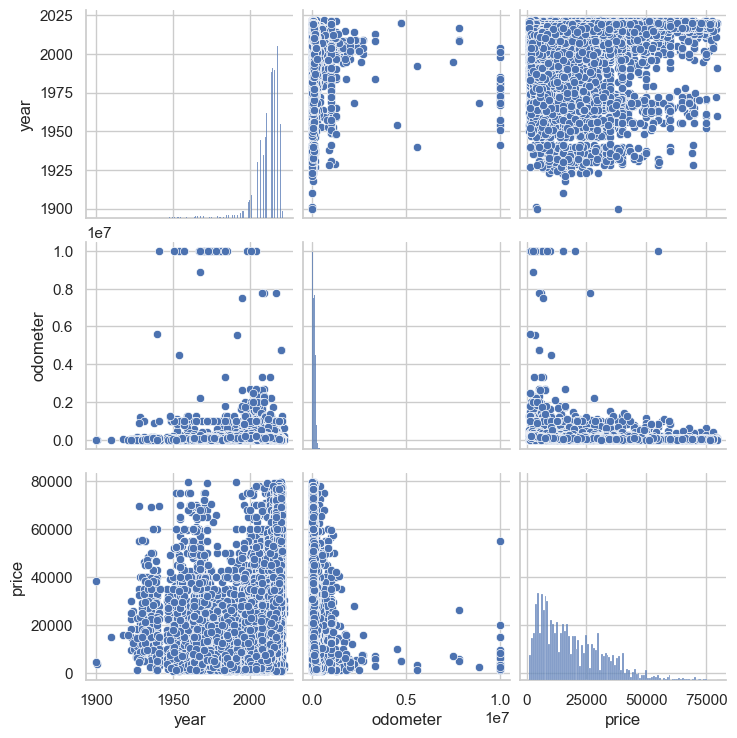

In [ ]:
# Using pairplot
print("\nPairplot for numerical variables:")
sns.pairplot(cars_df)
plt.show()

## Bar Plot of Car Pricing vs Manufacturer

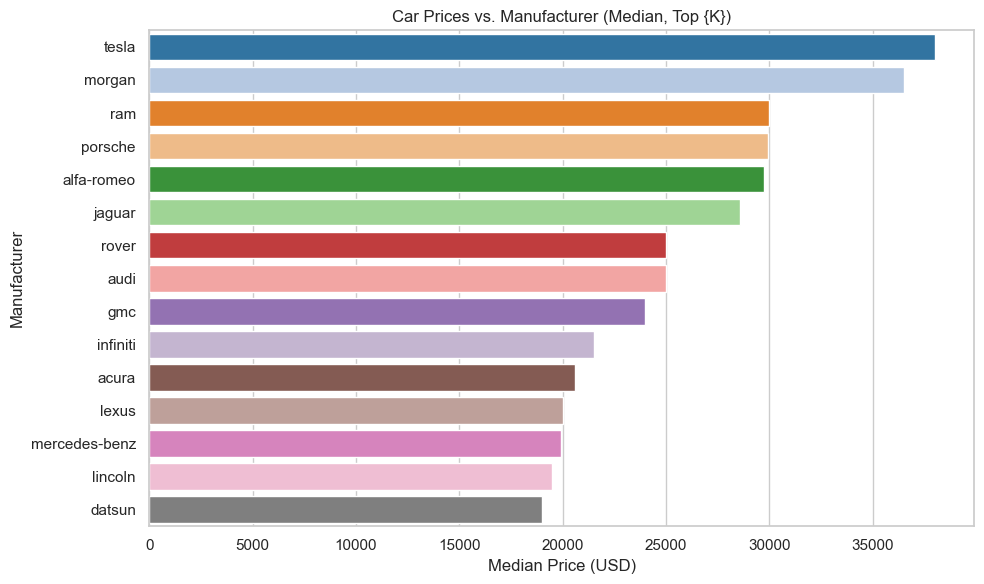

In [ ]:

# --- Multi-color bar: Car Prices vs Manufacturer (median price, top-K) ---

# 1) Aggregate to one row per manufacturer (median price)
agg = (cars_df
       .dropna(subset=['manufacturer', 'price'])
       .groupby('manufacturer', as_index=False)['price']
       .median())

# 2) Keep the top-K by median price (adjust K as you like)
K = 15
agg = agg.sort_values('price', ascending=False).head(K)

# 3) Plot: use hue=manufacturer (unique color per bar), disable dodge, hide legend
plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg,
    y='manufacturer',
    x='price',
    hue='manufacturer',      # one unique color per manufacturer
    dodge=False,             # ensure only one bar per category
    palette='tab20',         # try: 'tab10', 'Set3', 'Paired', or a custom dict
    legend=False
)
plt.title('Car Prices vs. Manufacturer (Median, Top {K})')
plt.ylabel('Manufacturer')
plt.xlabel('Median Price (USD)')
plt.tight_layout()
plt.show()



## Plot Price Vs. vehicle Type

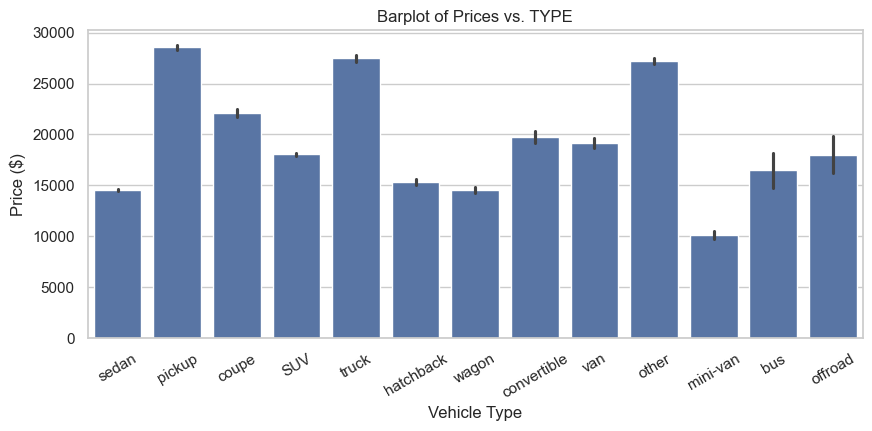

In [22]:

plt.figure(figsize=(10, 4))
sns.barplot(x='type', y='price', data=cars_df)
plt.title('Barplot of Prices vs. TYPE')
plt.xlabel('Vehicle Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=30)
plt.show()

## Modeling Strategy

We compare two pipelines:

1. **Ridge Regression** (linear baseline): One-hot encode selected categoricals, standardize numerics.
2. **Random Forest Regressor** (nonlinear): Ordinal-encode categoricals (arbitrary but effective for trees), no scaling.

We use a train/validation split and report MAE, RMSE, and R².


In [11]:

X = cars_df.drop(columns=[target_col])
y = cars_df[target_col].copy()

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Column groups ---
numeric_features = ['year', 'odometer']
categorical_features = [c for c in X.columns if c not in numeric_features]

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Pipeline A: Ridge (one‑hot + scale)
# NOTE: remove min_frequency to be compatible with older scikit‑learn releases
ridge_pre = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Ridge(random_state=...) is allowed but only used by certain solvers; keep it simple
ridge_model = Pipeline([
    ('prep', ridge_pre),
    ('est', Ridge(alpha=2.0))
])

# Pipeline B: RandomForest (ordinal encode)
# Ensure OrdinalEncoder can handle unknowns; set dtype=float to avoid dtype complaints on some versions
rf_pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numeric_features),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float))
    ]), categorical_features)
], remainder='drop')

rf_model = Pipeline([
    ('prep', rf_pre),
    ('est', RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42))
])

# --- Fit ---
ridge_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# --- Evaluator: avoid globals; pass X/y explicitly so it works in any scope --


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_model(name, model, X_val, y_val):
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    mse = mean_squared_error(y_val, pred)     # always valid
    rmse = np.sqrt(mse)                        # manual RMSE
    r2 = r2_score(y_val, pred)
    print(f"{name}: MAE={mae:,.0f}  RMSE={rmse:,.0f}  R^2={r2:.3f}")

eval_model('Ridge', ridge_model, X_valid, y_valid)
eval_model('RandomForest', rf_model, X_valid, y_valid)


Ridge: MAE=7,121  RMSE=9,824  R^2=0.492
RandomForest: MAE=2,944  RMSE=5,230  R^2=0.856


,feature,importance
0,year,0.624349
1,odometer,0.288081
4,cylinders,0.209802
5,fuel,0.174310
10,type,0.120330
2,manufacturer,0.101969
8,drive,0.099322
7,transmission,0.048323
12,state,0.017895
11,paint_color,0.013376


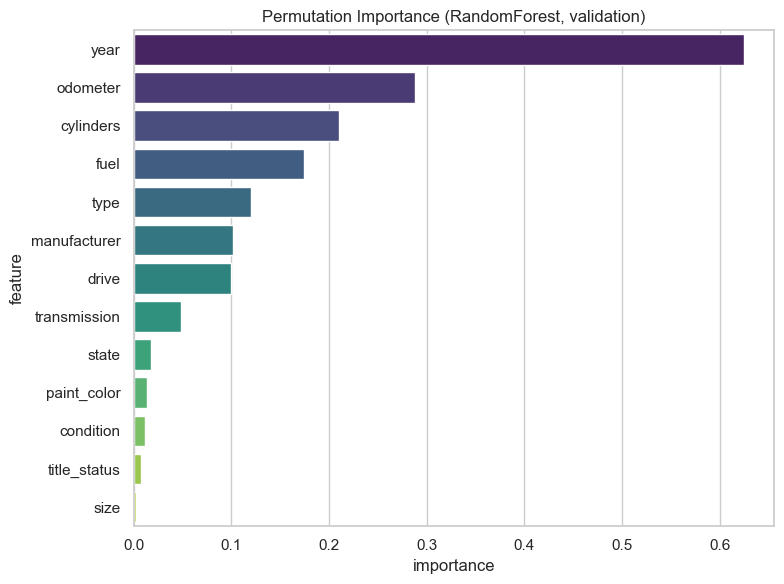

In [12]:
# Feature importance from RandomForest (via permutation importance on validation)
perm = permutation_importance(rf_model, X_valid, y_valid, n_repeats=5, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({'feature': X_valid.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
display(imp_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Permutation Importance (RandomForest, validation)')
plt.tight_layout(); plt.show()


## Conclusions & Recommendations

**What typically drives price** (your run may vary by sample and filters):

- **Model year** and **odometer** are consistently top predictors — newer, lower-mileage cars command higher prices.
- Equipment and risk proxies matter: **condition**, **transmission** (often automatic), **drive** (e.g., 4wd/awd), and **fuel** can shift prices.
- **Manufacturer** effects persist (brand/luxury premium); focus on makes with strong median resale.

**What to do with this insight**:

1. Prioritize acquiring newer, lower-mileage inventory in strong brands/segments.
2. Price guidance: use the Random Forest estimates as a starting point, then apply domain judgment (seasonality, local demand).
3. Data quality: capture odometer, condition, and drivetrain consistently to improve model stability.


